In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/PROJECT DS LAB/dataset.zip'

# Import librerie e Pre-Processing Immagini

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [ ]:
imagePaths = paths.list_images('/content/dataset') 

data = []
labels = []
# iterazione sul percorso delle immagini
for imagePath in imagePaths:
    # estraggo la class label dal nome de file
    label = imagePath.split(os.path.sep)[-2]
    # carico le immagini di input (224x224) e avvio il pre-processing
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)  # standardizza le immagini secondo le dimensioni di input preferite dal modello.
    # aggiorno data, label e liste
    data.append(image)
    labels.append(label)
# converto i dati e le labels in array di Numpy
data = np.array(data, dtype="float32")
labels = np.array(labels)
print('Finished...')

Finished...


In [ ]:
print(labels)

In [ ]:
# eseguo il one-hot encoding sulle labels delle immagini
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
print('Encoded')

Encoded


In [ ]:
# partiziono i dati in training set e test set. 
#Lo split applicato è di tipo 80-20 con compionamento stratificato sulle labels
 
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                 test_size=0.20, stratify=labels,
                                 random_state=40)

#trainY = np.asarray(trainY).astype('float32').reshape((-1,1))
#testY = np.asarray(trainY).astype('float32').reshape((-1,1))

In [ ]:
trainX
testX
trainY
testY

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [ ]:
#Definisco una funzione che permette di aggiungere rumore all'immagine applicando trasformazioni all'immagine di partenza. Così facendo, l'intenzione è quella di permettere al modello di
# ottenere una maggior capacità d generalizzazione.
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,            # tutti questi parametri sono dei 'range', ovvero le trasformazioni per ogni immagini saranno diverse.
    width_shift_range=0.2,       #  Ad ogni iterazione, eseguita dal metodo .flow, i parametri dell'augmentation varieranno casualmente entro i range fissati qui.
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [ ]:
# Stabilisco i parametri di partenza. In particolare, inizilizziamo il learning rate, il numero di epoche e la dimensione dei batches
INIT_LR = 1e-4
EPOCHS = 30
BS = 1
('Initialized...')

'Initialized...'

# Definizione Modello MobileNetV2

In [ ]:
# Carichiamo il modello MobileNetV2, 
# assicurandoci di non includere gli strati Fully Connected per ora.
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# Costruiamo la 'Head' del modello, che sarà posizionata sopra il Base Model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel) 
                        
# Posizioniamo la 'Head' del modello (che contiene i nostri strati Fully Connected) sopra il Base Model
model = Model(inputs=baseModel.input, outputs=headModel)

# Iteriamo sopra tutti gli strati del Base Model. Contestualmente applichiamo un Freeze, in modo che i relativi parametri 
# non vengano aggiornati durante il processo di training
for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
# Compiliamo il modello specificando la funzione di Ottimizzazione, la funzione di Perdita e la metrica per valutare la performance
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])
print('Compiled...')

Compiled...


In [ ]:
model.summary()

In [ ]:
# Fitting del Modello
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

In [ ]:
model.save('/content/drive/My Drive/Ds_lab/Modelli_Trained/MobileNet_ToBeTuned_', save_format="h5")

In [ ]:
# per ogni immagine nel test set troviamo l'indice della label alla quale è collegata la probabilità predetta più alta. 
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

# Printiamo un report della performance del modello
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

                   precision    recall  f1-score   support

   face_with_mask       0.98      0.99      0.99       441
face_without_mask       0.99      0.99      0.99       973

         accuracy                           0.99      1414
        macro avg       0.99      0.99      0.99      1414
     weighted avg       0.99      0.99      0.99      1414



<Figure size 432x288 with 0 Axes>

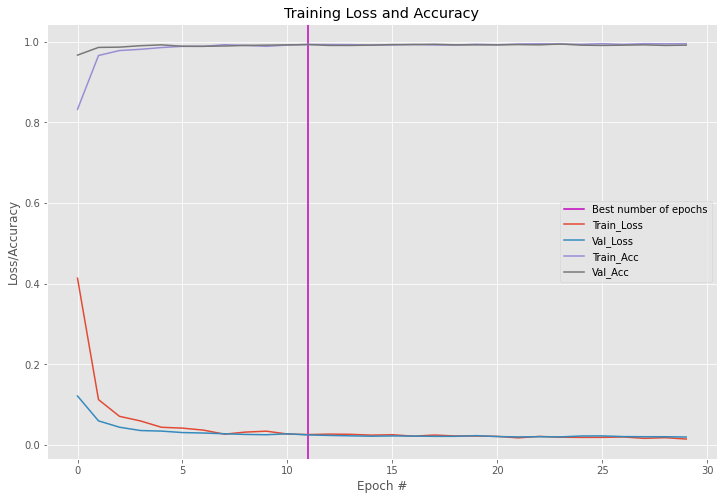

In [ ]:
## Plotting Training Loss Accuracy per Epoca
N = EPOCHS
H = history
START = 0
plt.style.use("ggplot")
plt.figure()
plt.figure(figsize=(12,8))
plt.axvline(11,label='Best number of epochs', color='m')
plt.plot(np.arange(START, N), H.history["loss"][START:30], label="Train_Loss")
plt.plot(np.arange(START, N), H.history["val_loss"][START:30], label="Val_Loss")
plt.plot(np.arange(START, N), H.history["accuracy"][START:30], label="Train_Acc")
plt.plot(np.arange(START, N), H.history["val_accuracy"][START:30], label="Val_Acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig('/content/drive/My Drive/Ds_lab/Modelli_Trained/Training_Loss_Accuracy.jpg')

# Importo il Face Detector e il Face_Mask Detector

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os

In [ ]:
prototxtPath = os.path.sep.join(['/content/drive/My Drive/PROJECT DS LAB/face_detector/', "deploy.prototxt"])
weightsPath = os.path.sep.join(['/content/drive/My Drive/PROJECT DS LAB/face_detector/',"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)
model = load_model('/content/drive/My Drive/PROJECT DS LAB/Modelli_Trained/MobileNet_Tuned_Hyperband2')

In [ ]:
image = cv2.imread(r'/content/drive/My Drive/PROJECT DS LAB/self-built-masked-face-recognition-dataset/dataset/examples/example_03.png')
#image = cv2.imread('/content/drive/My Drive/PROJECT DS LAB/self-built-masked-face-recognition-dataset/Tia_Example/tia1.jpg')
#image = cv2.imread('/content/drive/My Drive/PROJECT DS LAB/self-built-masked-face-recognition-dataset/Tia_Example/tia2.jpg')
#image = cv2.imread('/content/drive/My Drive/PROJECT DS LAB/self-built-masked-face-recognition-dataset/Tia_Example/tia3.jpg')
#image = cv2.imread('/content/drive/My Drive/PROJECT DS LAB/self-built-masked-face-recognition-dataset/Tia_Example/tia4.jpg')

#Estraggo i valori di hight e width
(h, w) = image.shape[:2]
#Costruisco un blob dall'immagine
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))
#Passo il blob al Face Network che mi fornisce le face detections
net.setInput(blob)
detections = net.forward()

In [ ]:
for i in range(0, detections.shape[2]):
    #Per ciascuna detections, estraggo il valore della confidenza
    confidence = detections[0, 0, i, 2]
    #Considero solo le detections che hanno una condifenza maggiore di una determinata soglia
    if confidence > 0.4:
        #Considero le coordinate del box in cui è presente la faccia
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        #Mi assicuro che il box in cui è presente l'immagine sta all'interno del 
        #frame
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
        
        #Estraggo dall'immagine la ROI
        face = image[startY:endY, startX:endX]
        #Converto l'immagine da BGR a RGB
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        #Resize della faccia in quanto la rete LeNet è allenata su immagini
        #di dimensione 224x224
        face = cv2.resize(face, (224, 224))
        #Trasformo in array
        face = img_to_array(face)
        #Preprocess dell'immagine
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)
        
        #Passo la faccia al modello LeNet
        (mask, withoutMask) = model.predict(face)[0]
        #Determino se la faccia ha o meno la maschera e definisco
        #il colore rosso per No Mask e verde per Mask. 
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        #Formatto la probabilità delle label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
        #Predispongo la visualzzione del frame, della label
        # e della probabilità prevista dal modello
        cv2.putText(image, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
        print(label)

No Mask: 100.00%
No Mask: 62.08%
Mask: 100.00%


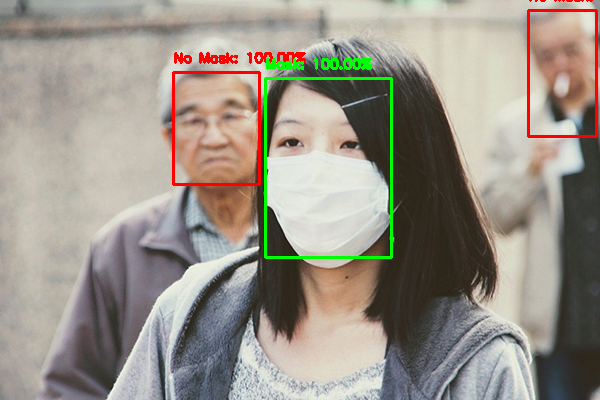

-1

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(image)
cv2.waitKey(0)

# FINE TUNING

In [ ]:
import tensorflow.python.keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras import backend as K

from tensorflow.python.keras import utils, layers, Sequential

!pip install -U keras-tuner
import kerastuner
from kerastuner import RandomSearch
from kerastuner import BayesianOptimization
from kerastuner import Hyperband
import pandas as pd
import numpy as np
import os

     |████████████████████████████████| 61kB 4.6MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=74dbea8a1aa3eef224af25dd967e4da21700098c8bbd7fdad6e36e60c80fb439
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=b8aec9279a3f603fe47e9cb61a43e5d3db89cfe807fd09907cc13c765d29cadf
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
def create_model(hp):
    dropout1 = hp.Choice('dropout', values=[0.34, 0.35, 0.42, 0.44, 0.5, 0.79])
    activation1 = hp.Choice('activation', values=['tanh', 'softmax', 'sigmoid', 'relu','elu', 'hard_sigmoid', 'selu'])

 

    def get_optimizer(optimizer, lr):
        if optimizer == 'adam':
            return tensorflow.keras.optimizers.Adam(learning_rate=lr)
        elif optimizer == 'rmsprop':
            return tensorflow.keras.optimizers.RMSprop(learning_rate=lr)
        elif optimizer == 'sgd':
            return tensorflow.keras.optimizers.SGD(learning_rate=lr)

 

    lr = hp.Choice('lr', values=[0.0011, 0.0331, 0.0464, 0.0654, 0.0926, 1e-4])
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])

 

    optimizer = get_optimizer(optimizer, lr)

 
    # Carichiamo il modello MobileNetV2, 
    # assicurandoci di non includere gli strati Fully Connected per ora.
    baseModel = MobileNetV2(weights="imagenet", include_top=False,
        input_tensor=Input(shape=(224, 224, 3)))

    # Costruiamo la 'Head' del modello, che sarà posizionata sopra il Base Model
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(2, activation="softmax")(headModel) 
                            
    # Posizioniamo la 'Head' del modello (che contiene i nostri strati Fully Connected) sopra il Base Model
    model = Model(inputs=baseModel.input, outputs=headModel)

    # Iteriamo sopra tutti gli strati del Base Model. COntestualmente applichiamo un Freeze, in modo che i relativi parametri 
    # non vengano aggiornati durante il primo processo di training
    for layer in baseModel.layers:
        layer.trainable = False

 


    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    return model

In [ ]:
#tuner = RandomSearch(create_model, executions_per_trial=2, objective=kerastuner.Objective("loss", direction="min"),
#                     max_trials = 10, 
#                     project_name='MobileNetV2_RandomSearch',
#                     directory='/content/drive/My Drive/Ds_lab/MobileNetV2_RandomSearch',
#                     seed = 795)

#tuner = kerastuner.tuners.bayesian.BayesianOptimization(create_model, 
#                                                        objective = kerastuner.Objective("loss", direction = "min"),
#                                                        executions_per_trial = 2, 
#                                                        max_trials = 10, 
#                                                        num_initial_points = 10, 
#                                                        seed=123,
#                                                        directory = '/content/drive/My Drive/Ds_lab/MobileNet_Bayesian',
#                                                        project_name='MobileNetV2_Bayesian') 

tuner = kerastuner.tuners.hyperband.Hyperband(create_model,
                                              
                                              objective = kerastuner.Objective("loss", direction = "min"), 
                                              max_epochs = 15,
                                              hyperband_iterations = 5, 
                                              factor = 3,
                                              directory = '/content/drive/My Drive/Ds_lab/MobileNet_HyperbandTune',
                                              project_name = 'MobileNet_HyperbandTune',
                                              seed = 355)                       

INFO:tensorflow:Reloading Oracle from existing project /content/drive/My Drive/Ds_lab/MobileNet_HyperbandTune/MobileNet_HyperbandTune/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/My Drive/Ds_lab/MobileNet_HyperbandTune/MobileNet_HyperbandTune/tuner0.json


In [ ]:
search_space = tuner.search_space_summary()
search_space

In [ ]:
tuner.search(x=trainX, y=trainY, epochs = 12, batch_size = 128,
             callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=3)], 
             validation_data=(testX, testY))


Epoch 1/2
45/45 [==============================] - 10s 216ms/step - loss: 0.1394 - accuracy: 0.9448 - val_loss: 0.0268 - val_accuracy: 0.9915
Epoch 2/2
45/45 [==============================] - 9s 200ms/step - loss: 0.0251 - accuracy: 0.9924 - val_loss: 0.0231 - val_accuracy: 0.9929


Epoch 1/2
45/45 [==============================] - 10s 215ms/step - loss: 0.1304 - accuracy: 0.9445 - val_loss: 0.0306 - val_accuracy: 0.9894
Epoch 2/2
45/45 [==============================] - 9s 200ms/step - loss: 0.0220 - accuracy: 0.9924 - val_loss: 0.0300 - val_accuracy: 0.9901


Epoch 1/2
45/45 [==============================] - 10s 219ms/step - loss: 0.1874 - accuracy: 0.9284 - val_loss: 0.0315 - val_accuracy: 0.9880
Epoch 2/2
45/45 [==============================] - 9s 198ms/step - loss: 0.0282 - accuracy: 0.9915 - val_loss: 0.0249 - val_accuracy: 0.9901


Epoch 3/4
45/45 [==============================] - 10s 214ms/step - loss: 0.1783 - accuracy: 0.9298 - val_loss: 0.0274 - val_accuracy: 0.9894
Epoch 4/4
45/45 [==============================] - 9s 200ms/step - loss: 0.0251 - accuracy: 0.9933 - val_loss: 0.0231 - val_accuracy: 0.9922


Epoch 3/4
45/45 [==============================] - 10s 214ms/step - loss: 0.1163 - accuracy: 0.9491 - val_loss: 0.0249 - val_accuracy: 0.9908
Epoch 4/4
45/45 [==============================] - 9s 199ms/step - loss: 0.0214 - accuracy: 0.9929 - val_loss: 0.0194 - val_accuracy: 0.9936


Epoch 3/4
45/45 [==============================] - 10s 213ms/step - loss: 0.1510 - accuracy: 0.9381 - val_loss: 0.0328 - val_accuracy: 0.9901
Epoch 4/4
45/45 [==============================] - 9s 200ms/step - loss: 0.0219 - accuracy: 0.9920 - val_loss: 0.0236 - val_accuracy: 0.9887


Epoch 3/4
45/45 [==============================] - 10s 215ms/step - loss: 0.1175 - accuracy: 0.9535 - val_loss: 0.0263 - val_accuracy: 0.9901
Epoch 4/4
45/45 [==============================] - 9s 201ms/step - loss: 0.0231 - accuracy: 0.9915 - val_loss: 0.0207 - val_accuracy: 0.9922


Epoch 5/10
45/45 [==============================] - 10s 212ms/step - loss: 0.1246 - accuracy: 0.9486 - val_loss: 0.0279 - val_accuracy: 0.9908
Epoch 6/10
45/45 [==============================] - 9s 201ms/step - loss: 0.0213 - accuracy: 0.9940 - val_loss: 0.0223 - val_accuracy: 0.9915
Epoch 7/10
45/45 [==============================] - 9s 200ms/step - loss: 0.0163 - accuracy: 0.9959 - val_loss: 0.0225 - val_accuracy: 0.9943
Epoch 8/10
45/45 [==============================] - 9s 196ms/step - loss: 0.0169 - accuracy: 0.9954 - val_loss: 0.0199 - val_accuracy: 0.9943
Epoch 9/10
45/45 [==============================] - 9s 198ms/step - loss: 0.0135 - accuracy: 0.9963 - val_loss: 0.0179 - val_accuracy: 0.9936
Epoch 10/10
45/45 [==============================] - 9s 198ms/step - loss: 0.0099 - accuracy: 0.9970 - val_loss: 0.0170 - val_accuracy: 0.9936


Epoch 5/10
45/45 [==============================] - 9s 211ms/step - loss: 0.1422 - accuracy: 0.9417 - val_loss: 0.0304 - val_accuracy: 0.9894
Epoch 6/10
45/45 [==============================] - 9s 201ms/step - loss: 0.0232 - accuracy: 0.9928 - val_loss: 0.0229 - val_accuracy: 0.9922
Epoch 7/10
45/45 [==============================] - 9s 199ms/step - loss: 0.0188 - accuracy: 0.9942 - val_loss: 0.0200 - val_accuracy: 0.9936
Epoch 8/10
45/45 [==============================] - 9s 199ms/step - loss: 0.0168 - accuracy: 0.9952 - val_loss: 0.0180 - val_accuracy: 0.9936
Epoch 9/10
45/45 [==============================] - 9s 198ms/step - loss: 0.0127 - accuracy: 0.9970 - val_loss: 0.0170 - val_accuracy: 0.9936
Epoch 10/10
45/45 [==============================] - 9s 199ms/step - loss: 0.0121 - accuracy: 0.9966 - val_loss: 0.0167 - val_accuracy: 0.9936


Epoch 1/4
45/45 [==============================] - 10s 216ms/step - loss: 0.1607 - accuracy: 0.9360 - val_loss: 0.0398 - val_accuracy: 0.9873
Epoch 2/4
45/45 [==============================] - 9s 201ms/step - loss: 0.0240 - accuracy: 0.9940 - val_loss: 0.0235 - val_accuracy: 0.9922
Epoch 3/4
45/45 [==============================] - 9s 201ms/step - loss: 0.0198 - accuracy: 0.9933 - val_loss: 0.0230 - val_accuracy: 0.9929
Epoch 4/4
45/45 [==============================] - 9s 200ms/step - loss: 0.0173 - accuracy: 0.9952 - val_loss: 0.0183 - val_accuracy: 0.9929


Epoch 1/4
45/45 [==============================] - 10s 217ms/step - loss: 0.1391 - accuracy: 0.9409 - val_loss: 0.0265 - val_accuracy: 0.9915
Epoch 2/4
45/45 [==============================] - 9s 200ms/step - loss: 0.0243 - accuracy: 0.9926 - val_loss: 0.0292 - val_accuracy: 0.9922
Epoch 3/4
45/45 [==============================] - 9s 197ms/step - loss: 0.0194 - accuracy: 0.9952 - val_loss: 0.0201 - val_accuracy: 0.9936
Epoch 4/4
45/45 [==============================] - 9s 199ms/step - loss: 0.0144 - accuracy: 0.9958 - val_loss: 0.0196 - val_accuracy: 0.9936


Epoch 1/4
45/45 [==============================] - 10s 213ms/step - loss: 0.1882 - accuracy: 0.9257 - val_loss: 0.0338 - val_accuracy: 0.9908
Epoch 2/4
45/45 [==============================] - 9s 199ms/step - loss: 0.0292 - accuracy: 0.9922 - val_loss: 0.0266 - val_accuracy: 0.9908
Epoch 3/4
45/45 [==============================] - 9s 200ms/step - loss: 0.0227 - accuracy: 0.9931 - val_loss: 0.0244 - val_accuracy: 0.9929
Epoch 4/4
45/45 [==============================] - 9s 198ms/step - loss: 0.0174 - accuracy: 0.9947 - val_loss: 0.0230 - val_accuracy: 0.9936


Epoch 1/4
45/45 [==============================] - 10s 214ms/step - loss: 0.1200 - accuracy: 0.9531 - val_loss: 0.0331 - val_accuracy: 0.9894
Epoch 2/4
45/45 [==============================] - 9s 199ms/step - loss: 0.0253 - accuracy: 0.9926 - val_loss: 0.0219 - val_accuracy: 0.9922
Epoch 3/4
45/45 [==============================] - 9s 199ms/step - loss: 0.0171 - accuracy: 0.9959 - val_loss: 0.0196 - val_accuracy: 0.9929
Epoch 4/4
45/45 [==============================] - 9s 199ms/step - loss: 0.0158 - accuracy: 0.9947 - val_loss: 0.0188 - val_accuracy: 0.9936


Epoch 1/4
45/45 [==============================] - 10s 212ms/step - loss: 0.0991 - accuracy: 0.9623 - val_loss: 0.0237 - val_accuracy: 0.9901
Epoch 2/4
45/45 [==============================] - 9s 200ms/step - loss: 0.0225 - accuracy: 0.9928 - val_loss: 0.0191 - val_accuracy: 0.9922
Epoch 3/4
45/45 [==============================] - 9s 199ms/step - loss: 0.0151 - accuracy: 0.9958 - val_loss: 0.0183 - val_accuracy: 0.9929
Epoch 4/4
45/45 [==============================] - 9s 198ms/step - loss: 0.0144 - accuracy: 0.9959 - val_loss: 0.0189 - val_accuracy: 0.9936


Epoch 1/4
45/45 [==============================] - 10s 213ms/step - loss: 0.2034 - accuracy: 0.9227 - val_loss: 0.0300 - val_accuracy: 0.9915
Epoch 2/4
45/45 [==============================] - 9s 198ms/step - loss: 0.0314 - accuracy: 0.9905 - val_loss: 0.0243 - val_accuracy: 0.9908
Epoch 3/4
45/45 [==============================] - 9s 198ms/step - loss: 0.0237 - accuracy: 0.9938 - val_loss: 0.0226 - val_accuracy: 0.9915
Epoch 4/4
45/45 [==============================] - 9s 196ms/step - loss: 0.0191 - accuracy: 0.9950 - val_loss: 0.0200 - val_accuracy: 0.9922


Epoch 5/10
45/45 [==============================] - 10s 212ms/step - loss: 0.0976 - accuracy: 0.9620 - val_loss: 0.0257 - val_accuracy: 0.9922
Epoch 6/10
45/45 [==============================] - 9s 199ms/step - loss: 0.0250 - accuracy: 0.9924 - val_loss: 0.0222 - val_accuracy: 0.9936
Epoch 7/10
45/45 [==============================] - 9s 199ms/step - loss: 0.0188 - accuracy: 0.9935 - val_loss: 0.0192 - val_accuracy: 0.9936
Epoch 8/10
45/45 [==============================] - 9s 199ms/step - loss: 0.0141 - accuracy: 0.9958 - val_loss: 0.0181 - val_accuracy: 0.9936
Epoch 9/10
45/45 [==============================] - 9s 198ms/step - loss: 0.0114 - accuracy: 0.9970 - val_loss: 0.0193 - val_accuracy: 0.9936
Epoch 10/10
45/45 [==============================] - 9s 197ms/step - loss: 0.0096 - accuracy: 0.9979 - val_loss: 0.0174 - val_accuracy: 0.9936


Epoch 5/10
45/45 [==============================] - 10s 212ms/step - loss: 0.2257 - accuracy: 0.9169 - val_loss: 0.0346 - val_accuracy: 0.9859
Epoch 6/10
45/45 [==============================] - 9s 198ms/step - loss: 0.0307 - accuracy: 0.9899 - val_loss: 0.0304 - val_accuracy: 0.9887
Epoch 7/10
45/45 [==============================] - 9s 199ms/step - loss: 0.0249 - accuracy: 0.9922 - val_loss: 0.0260 - val_accuracy: 0.9894
Epoch 8/10
45/45 [==============================] - 9s 199ms/step - loss: 0.0213 - accuracy: 0.9945 - val_loss: 0.0236 - val_accuracy: 0.9901
Epoch 9/10
45/45 [==============================] - 9s 202ms/step - loss: 0.0180 - accuracy: 0.9947 - val_loss: 0.0211 - val_accuracy: 0.9908
Epoch 10/10
45/45 [==============================] - 9s 197ms/step - loss: 0.0143 - accuracy: 0.9958 - val_loss: 0.0212 - val_accuracy: 0.9908


Epoch 1/10
45/45 [==============================] - 10s 213ms/step - loss: 0.1183 - accuracy: 0.9478 - val_loss: 0.0310 - val_accuracy: 0.9887
Epoch 2/10
45/45 [==============================] - 9s 199ms/step - loss: 0.0261 - accuracy: 0.9913 - val_loss: 0.0231 - val_accuracy: 0.9929
Epoch 3/10
45/45 [==============================] - 9s 199ms/step - loss: 0.0176 - accuracy: 0.9954 - val_loss: 0.0201 - val_accuracy: 0.9936
Epoch 4/10
45/45 [==============================] - 9s 198ms/step - loss: 0.0143 - accuracy: 0.9950 - val_loss: 0.0198 - val_accuracy: 0.9922
Epoch 5/10
45/45 [==============================] - 9s 199ms/step - loss: 0.0129 - accuracy: 0.9970 - val_loss: 0.0181 - val_accuracy: 0.9922
Epoch 6/10
45/45 [==============================] - 9s 200ms/step - loss: 0.0098 - accuracy: 0.9972 - val_loss: 0.0197 - val_accuracy: 0.9915
Epoch 7/10
45/45 [==============================] - 9s 198ms/step - loss: 0.0094 - accuracy: 0.9977 - val_loss: 0.0177 - val_accuracy: 0.9929
Epoch

Epoch 1/10
45/45 [==============================] - 10s 213ms/step - loss: 0.1100 - accuracy: 0.9546 - val_loss: 0.0251 - val_accuracy: 0.9915
Epoch 2/10
45/45 [==============================] - 9s 199ms/step - loss: 0.0216 - accuracy: 0.9936 - val_loss: 0.0220 - val_accuracy: 0.9922
Epoch 3/10
45/45 [==============================] - 9s 199ms/step - loss: 0.0195 - accuracy: 0.9949 - val_loss: 0.0197 - val_accuracy: 0.9936
Epoch 4/10
45/45 [==============================] - 9s 201ms/step - loss: 0.0118 - accuracy: 0.9968 - val_loss: 0.0185 - val_accuracy: 0.9936
Epoch 5/10
45/45 [==============================] - 9s 194ms/step - loss: 0.0139 - accuracy: 0.9965 - val_loss: 0.0172 - val_accuracy: 0.9936
Epoch 6/10
45/45 [==============================] - 9s 198ms/step - loss: 0.0108 - accuracy: 0.9966 - val_loss: 0.0178 - val_accuracy: 0.9936
Epoch 7/10
45/45 [==============================] - 9s 200ms/step - loss: 0.0087 - accuracy: 0.9973 - val_loss: 0.0152 - val_accuracy: 0.9936
Epoch

Epoch 1/10
45/45 [==============================] - 10s 211ms/step - loss: 0.0916 - accuracy: 0.9661 - val_loss: 0.0231 - val_accuracy: 0.9901
Epoch 2/10
45/45 [==============================] - 9s 196ms/step - loss: 0.0213 - accuracy: 0.9940 - val_loss: 0.0222 - val_accuracy: 0.9908
Epoch 3/10
45/45 [==============================] - 9s 197ms/step - loss: 0.0147 - accuracy: 0.9956 - val_loss: 0.0154 - val_accuracy: 0.9943
Epoch 4/10
45/45 [==============================] - 9s 198ms/step - loss: 0.0126 - accuracy: 0.9961 - val_loss: 0.0150 - val_accuracy: 0.9936
Epoch 5/10
45/45 [==============================] - 9s 197ms/step - loss: 0.0114 - accuracy: 0.9965 - val_loss: 0.0169 - val_accuracy: 0.9936
Epoch 6/10
45/45 [==============================] - 9s 197ms/step - loss: 0.0094 - accuracy: 0.9968 - val_loss: 0.0146 - val_accuracy: 0.9943
Epoch 7/10
45/45 [==============================] - 9s 193ms/step - loss: 0.0104 - accuracy: 0.9968 - val_loss: 0.0138 - val_accuracy: 0.9943
Epoch

Epoch 1/10
45/45 [==============================] - 10s 213ms/step - loss: 0.1303 - accuracy: 0.9475 - val_loss: 0.0333 - val_accuracy: 0.9901
Epoch 2/10
45/45 [==============================] - 9s 196ms/step - loss: 0.0225 - accuracy: 0.9926 - val_loss: 0.0239 - val_accuracy: 0.9936
Epoch 3/10
45/45 [==============================] - 9s 198ms/step - loss: 0.0187 - accuracy: 0.9938 - val_loss: 0.0242 - val_accuracy: 0.9929
Epoch 4/10
45/45 [==============================] - 9s 197ms/step - loss: 0.0132 - accuracy: 0.9970 - val_loss: 0.0211 - val_accuracy: 0.9943
Epoch 5/10
45/45 [==============================] - 9s 199ms/step - loss: 0.0115 - accuracy: 0.9968 - val_loss: 0.0211 - val_accuracy: 0.9936
Epoch 6/10
45/45 [==============================] - 9s 199ms/step - loss: 0.0113 - accuracy: 0.9966 - val_loss: 0.0193 - val_accuracy: 0.9929
Epoch 7/10
45/45 [==============================] - 9s 198ms/step - loss: 0.0104 - accuracy: 0.9961 - val_loss: 0.0187 - val_accuracy: 0.9943
Epoch

INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
#best_model.summary()

In [ ]:
## RANDOM SEARCH
loss, accuracy = best_model.evaluate(testX, testY)
print(loss)
print(accuracy)
# RANDOM SEARCH BEST
print(tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values)

45/45 [==============================] - 2s 42ms/step - loss: 0.0155 - accuracy: 0.9936
0.015488160774111748
0.9936350584030151
{'dropout': 0.34, 'activation': 'tanh', 'lr': 0.0331, 'optimizer': 'sgd'}


In [ ]:
## BAYESIAN
loss, accuracy = best_model.evaluate(testX, testY)
print(loss)
print(accuracy)

# BAYESIAN BEST
print(tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values)

45/45 [==============================] - 4s 86ms/step - loss: 0.0140 - accuracy: 0.9936
0.014016383327543736
0.9936350584030151
{'dropout': 0.44, 'activation': 'tanh', 'lr': 0.0926, 'optimizer': 'adam'}


In [ ]:
## HYPERBAND SEARCH
loss, accuracy = best_model.evaluate(testX, testY)
print(loss)
print(accuracy)
# RANDOM SEARCH BEST
print(tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values)

45/45 [==============================] - 2s 42ms/step - loss: 0.0131 - accuracy: 0.9943
0.013121945783495903
0.9943422675132751
{'dropout': 0.44, 'activation': 'tanh', 'lr': 0.0331, 'optimizer': 'rmsprop', 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


# Log Random Search

45/45 [==============================] - 2s 42ms/step 

loss: 0.0155 - accuracy: 0.9936

0.015488160774111748 ;
0.9936350584030151

{'dropout': 0.34, 'activation': 'tanh', 'lr': 0.0331, 'optimizer': 'sgd'}


# Log Bayesian Search

45/45 [==============================] - 4s 86ms/step -

loss: 0.0140 - accuracy: 0.9936

0.014016383327543736
0.9936350584030151

{'dropout': 0.44, 'activation': 'tanh', 'lr': 0.0926, 'optimizer': 'adam'}



# Log Hyperband Search

45/45 [==============================] - 2s 42ms/step -

loss: 0.0131 - accuracy: 0.9943

0.013121945783495903; 
0.9943422675132751

{'dropout': 0.44, 'activation': 'tanh', 'lr': 0.0331, 'optimizer': 'rmsprop', 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}

In [ ]:
best_model.save('/content/drive/My Drive/Ds_lab/Modelli_Trained/Mobilet_tuned_Bayesian', save_format="h5")

# COSTRUZIONE MODELLI BEST

## Hyperband Search Best
{'dropout': 0.44, 'activation': 'tanh', 'lr': 0.0331, 'optimizer': 'rmsprop', 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}

Compiled...
Epoch 1/15
44/44 [==============================] - 60s 1s/step - loss: 1.0978 - accuracy: 0.7668 - val_loss: 0.0702 - val_accuracy: 0.9795
Epoch 2/15
44/44 [==============================] - 58s 1s/step - loss: 0.2523 - accuracy: 0.9309 - val_loss: 0.0501 - val_accuracy: 0.9894
Epoch 3/15
44/44 [==============================] - 59s 1s/step - loss: 0.1847 - accuracy: 0.9493 - val_loss: 0.1530 - val_accuracy: 0.9554
Epoch 4/15
44/44 [==============================] - 59s 1s/step - loss: 0.1278 - accuracy: 0.9691 - val_loss: 0.0445 - val_accuracy: 0.9908
Epoch 5/15
44/44 [==============================] - 59s 1s/step - loss: 0.1186 - accuracy: 0.9723 - val_loss: 0.0583 - val_accuracy: 0.9844
Epoch 6/15
44/44 [==============================] - 59s 1s/step - loss: 0.1123 - accuracy: 0.9736 - val_loss: 0.0723 - val_accuracy: 0.9823
Epoch 7/15
44/44 [==============================] - 57s 1s/step - loss: 0.0798 - accuracy: 0.9790 - val_loss: 0.0718 - val_accuracy: 0.9873
Epoch 8/

<Figure size 432x288 with 0 Axes>

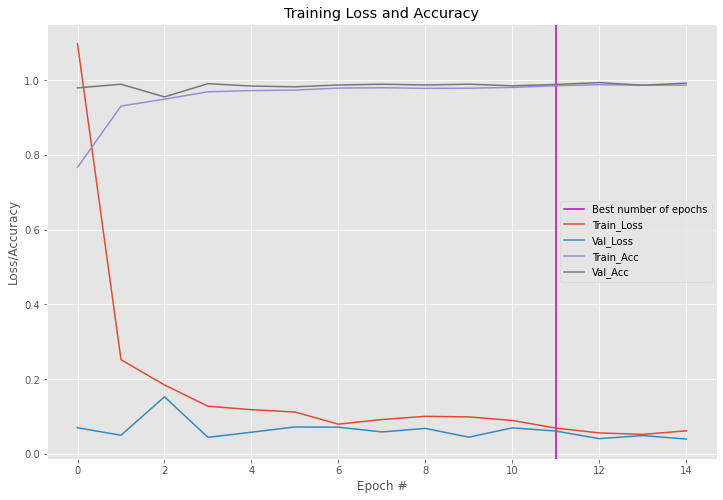

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

# Stabilisco i parametri di partenza. In particolare, inizilizziamo il learning rate, il numero di epoche e la dimensione dei batches
INIT_LR = 0.0331
EPOCHS = 15
BS = 128
('Initialized...')

# Carichiamo il modello MobileNetV2, 
# assicurandoci di non includere gli strati Fully Connected per ora.
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# Costruiamo la 'Head' del modello, che sarà posizionata sopra il Base Model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="tanh")(headModel)
headModel = Dropout(0.44)(headModel)
headModel = Dense(2, activation="softmax")(headModel) 
                        
# Posizioniamo la 'Head' del modello (che contiene i nostri strati Fully Connected) sopra il Base Model
model = Model(inputs=baseModel.input, outputs=headModel)

# Iteriamo sopra tutti gli strati del Base Model. COntestualmente applichiamo un Freeze, in modo che i relativi parametri 
# non vengano aggiornati durante il primo processo di training
for layer in baseModel.layers:
    layer.trainable = False


# Compiliamo il modello specificando la funzione di Ottimizzazione, la funzione di Perdita e la metrica per valutare la performance
opt = RMSprop(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])
print('Compiled...')

# Fitting del Modello
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

model.save('/content/drive/My Drive/Ds_lab/Modelli_Trained/MobileNet_Tuned_Hyperband2', save_format="h5")

# per ogni immagine nel test set troviamo l'indice della label alla quale è collegata la probabilità predetta più alta. 
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

# Printiamo un report della performance del modello
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

## Plotting Training Loss Accuracy per Epoca
N = EPOCHS
#H = history
START = 0
plt.style.use("ggplot")
plt.figure()
plt.figure(figsize=(12,8))
#plt.axvline(11,label='Best number of epochs', color='m')
plt.plot(np.arange(START, N), H.history["loss"][START:30], label="Train_Loss")
plt.plot(np.arange(START, N), H.history["val_loss"][START:30], label="Val_Loss")
plt.plot(np.arange(START, N), H.history["accuracy"][START:30], label="Train_Acc")
plt.plot(np.arange(START, N), H.history["val_accuracy"][START:30], label="Val_Acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig('/content/drive/My Drive/Ds_lab/Modelli_Trained/Training_Loss_Accuracy.jpg')

<Figure size 432x288 with 0 Axes>

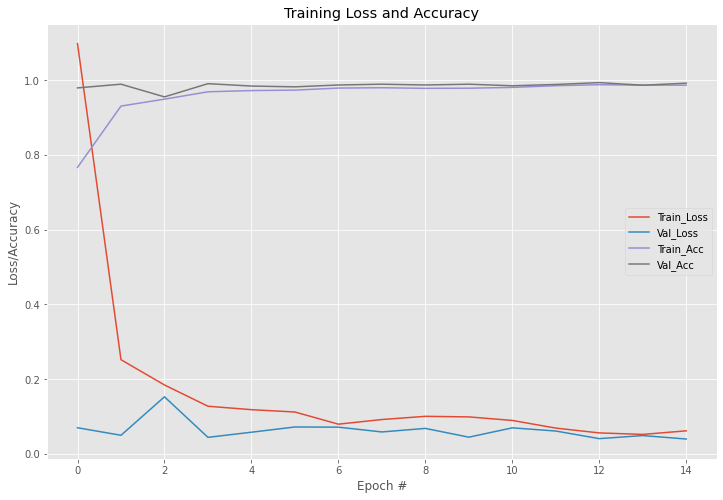

In [ ]:
## Plotting Training Loss Accuracy per Epoca
N = EPOCHS
#H = history
START = 0
plt.style.use("ggplot")
plt.figure()
plt.figure(figsize=(12,8))
#plt.axvline(11,label='Best number of epochs', color='m')
plt.plot(np.arange(START, N), H.history["loss"][START:30], label="Train_Loss")
plt.plot(np.arange(START, N), H.history["val_loss"][START:30], label="Val_Loss")
plt.plot(np.arange(START, N), H.history["accuracy"][START:30], label="Train_Acc")
plt.plot(np.arange(START, N), H.history["val_accuracy"][START:30], label="Val_Acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig('/content/drive/My Drive/Ds_lab/Modelli_Trained/Training_Loss_Accuracy_Hyperband.jpg')

In [ ]:
model.save('/content/drive/My Drive/Ds_lab/Modelli_Trained/MobileNet_Tuned_Hyperband2', save_format="h5")

## Best Bayesian

{'dropout': 0.44, 'activation': 'tanh', 'lr': 0.0926, 'optimizer': 'adam'}

Compiled...
Epoch 1/15
44/44 [==============================] - 59s 1s/step - loss: 0.2073 - accuracy: 0.9562 - val_loss: 0.0924 - val_accuracy: 0.9859
Epoch 2/15
44/44 [==============================] - 57s 1s/step - loss: 0.2484 - accuracy: 0.9550 - val_loss: 0.0846 - val_accuracy: 0.9781
Epoch 3/15
44/44 [==============================] - 57s 1s/step - loss: 0.2385 - accuracy: 0.9555 - val_loss: 0.1443 - val_accuracy: 0.9675
Epoch 4/15
44/44 [==============================] - 57s 1s/step - loss: 0.3089 - accuracy: 0.9506 - val_loss: 0.1895 - val_accuracy: 0.9781
Epoch 5/15
44/44 [==============================] - 57s 1s/step - loss: 0.2580 - accuracy: 0.9580 - val_loss: 0.0879 - val_accuracy: 0.9788
Epoch 6/15
44/44 [==============================] - 58s 1s/step - loss: 0.2024 - accuracy: 0.9640 - val_loss: 0.1094 - val_accuracy: 0.9851
Epoch 7/15
44/44 [==============================] - 57s 1s/step - loss: 0.2408 - accuracy: 0.9568 - val_loss: 0.1911 - val_accuracy: 0.9583
Epoch 8/

<Figure size 432x288 with 0 Axes>

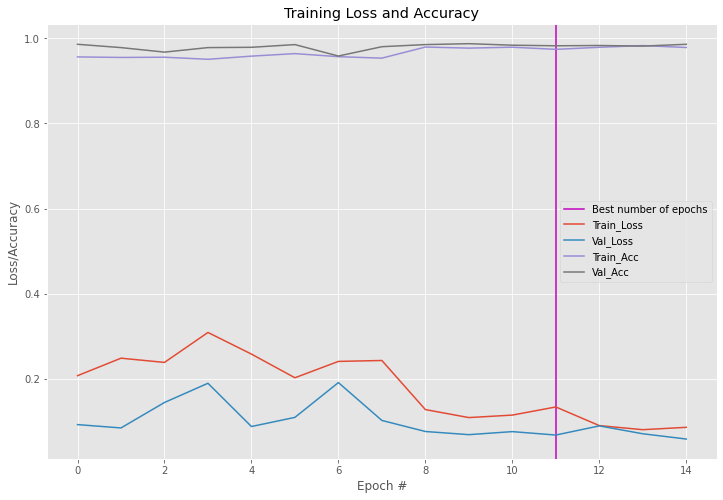

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

# Stabilisco i parametri di partenza. In particolare, inizilizziamo il learning rate, il numero di epoche e la dimensione dei batches
INIT_LR = 0.0926
EPOCHS = 15
BS = 128
('Initialized...')

# Carichiamo il modello MobileNetV2, 
# assicurandoci di non includere gli strati Fully Connected per ora.
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# Costruiamo la 'Head' del modello, che sarà posizionata sopra il Base Model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="tanh")(headModel)
headModel = Dropout(0.44)(headModel)
headModel = Dense(2, activation="softmax")(headModel) 
                        
# Posizioniamo la 'Head' del modello (che contiene i nostri strati Fully Connected) sopra il Base Model
model = Model(inputs=baseModel.input, outputs=headModel)

# Iteriamo sopra tutti gli strati del Base Model. COntestualmente applichiamo un Freeze, in modo che i relativi parametri 
# non vengano aggiornati durante il primo processo di training
for layer in baseModel.layers:
    layer.trainable = False


# Compiliamo il modello specificando la funzione di Ottimizzazione, la funzione di Perdita e la metrica per valutare la performance
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])
print('Compiled...')

# Fitting del Modello
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

model.save('/content/drive/My Drive/Ds_lab/Modelli_Trained/MobileNet_Tuned_Bayesian2', save_format="h5")

# per ogni immagine nel test set troviamo l'indice della label alla quale è collegata la probabilità predetta più alta. 
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

# Printiamo un report della performance del modello
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

## Plotting Training Loss Accuracy per Epoca
N = EPOCHS
#H = history
START = 0
plt.style.use("ggplot")
plt.figure()
plt.figure(figsize=(12,8))
plt.axvline(12,label='Best number of epochs', color='m')
plt.plot(np.arange(START, N), H.history["loss"][START:30], label="Train_Loss")
plt.plot(np.arange(START, N), H.history["val_loss"][START:30], label="Val_Loss")
plt.plot(np.arange(START, N), H.history["accuracy"][START:30], label="Train_Acc")
plt.plot(np.arange(START, N), H.history["val_accuracy"][START:30], label="Val_Acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig('/content/drive/My Drive/Ds_lab/Modelli_Trained/Training_Loss_Accuracy_BayesianBest.jpg')

<Figure size 432x288 with 0 Axes>

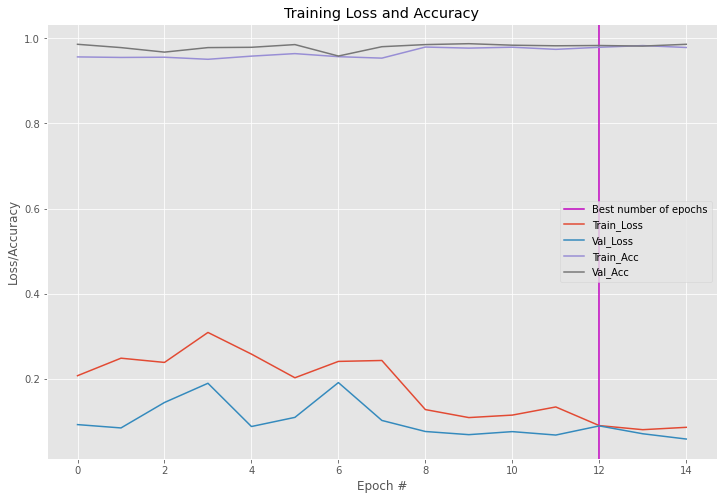

In [ ]:

## Plotting Training Loss Accuracy per Epoca
N = EPOCHS
#H = history
START = 0
plt.style.use("ggplot")
plt.figure()
plt.figure(figsize=(12,8))
plt.axvline(12,label='Best number of epochs', color='m')
plt.plot(np.arange(START, N), H.history["loss"][START:30], label="Train_Loss")
plt.plot(np.arange(START, N), H.history["val_loss"][START:30], label="Val_Loss")
plt.plot(np.arange(START, N), H.history["accuracy"][START:30], label="Train_Acc")
plt.plot(np.arange(START, N), H.history["val_accuracy"][START:30], label="Val_Acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig('/content/drive/My Drive/Ds_lab/Modelli_Trained/Training_Loss_Accuracy_BayesianBest.jpg')

## Random Search Best

{'dropout': 0.34, 'activation': 'tanh', 'lr': 0.0331, 'optimizer': 'sgd'}



Compiled...
Epoch 1/15
44/44 [==============================] - 58s 1s/step - loss: 0.1755 - accuracy: 0.9376 - val_loss: 0.0494 - val_accuracy: 0.9880
Epoch 2/15
44/44 [==============================] - 57s 1s/step - loss: 0.0499 - accuracy: 0.9875 - val_loss: 0.0404 - val_accuracy: 0.9887
Epoch 3/15
44/44 [==============================] - 56s 1s/step - loss: 0.0399 - accuracy: 0.9866 - val_loss: 0.0408 - val_accuracy: 0.9866
Epoch 4/15
44/44 [==============================] - 56s 1s/step - loss: 0.0326 - accuracy: 0.9904 - val_loss: 0.0334 - val_accuracy: 0.9887
Epoch 5/15
44/44 [==============================] - 56s 1s/step - loss: 0.0308 - accuracy: 0.9915 - val_loss: 0.0334 - val_accuracy: 0.9880
Epoch 6/15
44/44 [==============================] - 56s 1s/step - loss: 0.0266 - accuracy: 0.9928 - val_loss: 0.0305 - val_accuracy: 0.9901
Epoch 7/15
44/44 [==============================] - 56s 1s/step - loss: 0.0280 - accuracy: 0.9919 - val_loss: 0.0292 - val_accuracy: 0.9894
Epoch 8/

<Figure size 432x288 with 0 Axes>

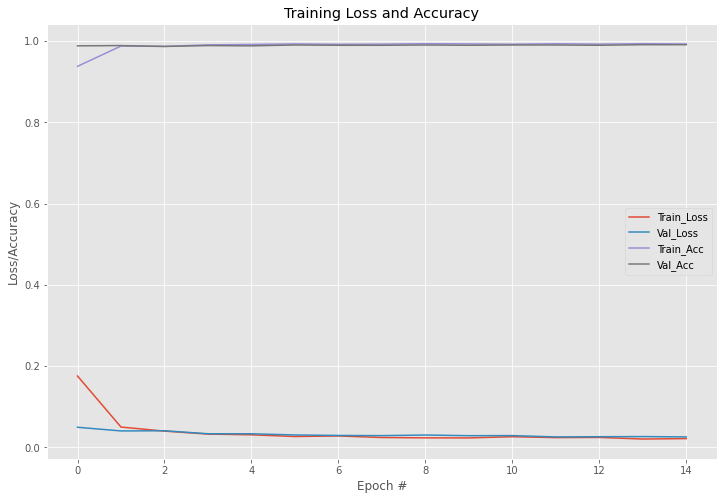

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

# Stabilisco i parametri di partenza. In particolare, inizilizziamo il learning rate, il numero di epoche e la dimensione dei batches
INIT_LR = 0.0331
EPOCHS = 15
BS = 128
('Initialized...')

# Carichiamo il modello MobileNetV2, 
# assicurandoci di non includere gli strati Fully Connected per ora.
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# Costruiamo la 'Head' del modello, che sarà posizionata sopra il Base Model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="tanh")(headModel)
headModel = Dropout(0.34)(headModel)
headModel = Dense(2, activation="softmax")(headModel) 
                        
# Posizioniamo la 'Head' del modello (che contiene i nostri strati Fully Connected) sopra il Base Model
model = Model(inputs=baseModel.input, outputs=headModel)

# Iteriamo sopra tutti gli strati del Base Model. COntestualmente applichiamo un Freeze, in modo che i relativi parametri 
# non vengano aggiornati durante il primo processo di training
for layer in baseModel.layers:
    layer.trainable = False


# Compiliamo il modello specificando la funzione di Ottimizzazione, la funzione di Perdita e la metrica per valutare la performance
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])
print('Compiled...')

# Fitting del Modello
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

model.save('/content/drive/My Drive/Ds_lab/Modelli_Trained/MobileNet_Tuned_RandomSearch2', save_format="h5")

# per ogni immagine nel test set troviamo l'indice della label alla quale è collegata la probabilità predetta più alta. 
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

# Printiamo un report della performance del modello
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

## Plotting Training Loss Accuracy per Epoca
N = EPOCHS
#H = history
START = 0
plt.style.use("ggplot")
plt.figure()
plt.figure(figsize=(12,8))
#plt.axvline(11,label='Best number of epochs', color='m')
plt.plot(np.arange(START, N), H.history["loss"][START:30], label="Train_Loss")
plt.plot(np.arange(START, N), H.history["val_loss"][START:30], label="Val_Loss")
plt.plot(np.arange(START, N), H.history["accuracy"][START:30], label="Train_Acc")
plt.plot(np.arange(START, N), H.history["val_accuracy"][START:30], label="Val_Acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig('/content/drive/My Drive/Ds_lab/Modelli_Trained/Training_Loss_Accuracy_RandomSearchBest.jpg')